# Laboratorio 3 - MLFLow & Feast

Diego Andrés Alonzo Medinilla - 20172

## Configuración del entorno

### Instalación de dependencias

In [1]:
%pip install mlflow feast scikit-learn pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Verificación de la instalación

In [3]:
import mlflow
import feast

print(mlflow.__version__)
print(feast.__version__)

3.5.0
0.47.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlflow import MlflowClient
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor

## Carga y exploración del dataset

### Carga del dataset

In [5]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
# TODO: Cargar el dataset
housing = fetch_california_housing()
# TODO: Convertir a DataFrame con nombres de columnas apropiados
df = pd.DataFrame(housing['data'])
df = df.rename(
    {
        0:'MedInc',
        1:'HouseAge',
        2:'AveRooms',
        3:'AveBedrms',
        4:'Population',
        5:'AveOccup',
        6:'Latitude',
        7:'Longitude',
        # 8:'MedHouseVal' # There is no MedHouseVal in the doc
    }, 
    axis=1)
df['MedHouseVal'] = housing['target']

In [6]:
# TODO: Mostrar las primeras 5 filas
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [7]:
# TODO: Mostrar información básica del dataset (shape, tipos de datos)
print(df.shape)
print(df.info())
df.describe()

(20640, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


### Análisis Exploratorio

In [8]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [9]:
for col in df.columns:
    print(f"{col} has # {df[df[col].isna()].shape[0]} nulls")

MedInc has # 0 nulls
HouseAge has # 0 nulls
AveRooms has # 0 nulls
AveBedrms has # 0 nulls
Population has # 0 nulls
AveOccup has # 0 nulls
Latitude has # 0 nulls
Longitude has # 0 nulls
MedHouseVal has # 0 nulls


array([[<Axes: title={'center': 'MedHouseVal'}>]], dtype=object)

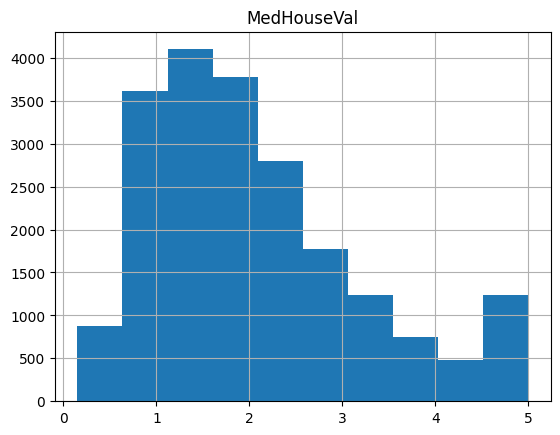

In [10]:
df.hist('MedHouseVal')

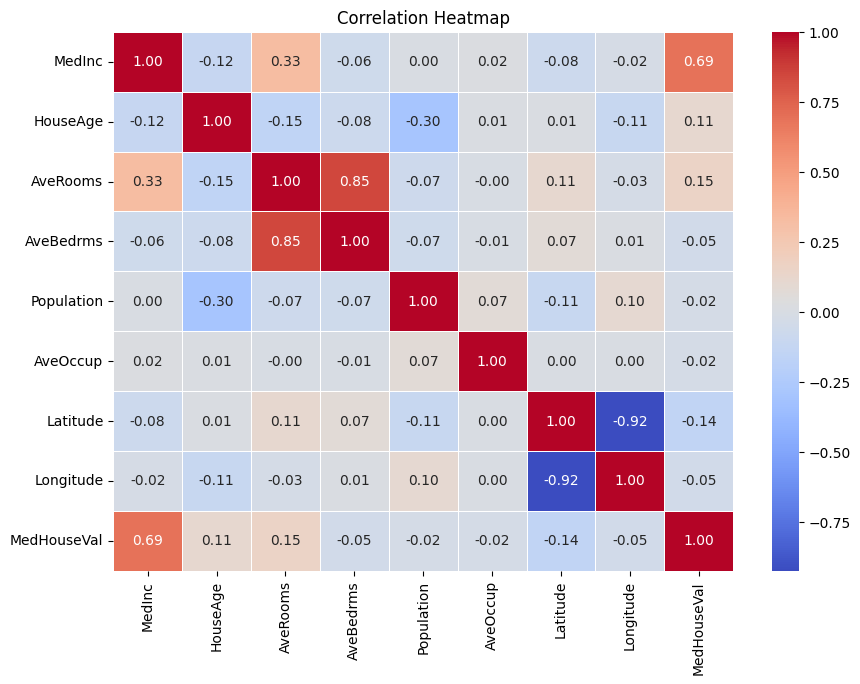

In [11]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Preparación de los Datos

### División de datos

In [12]:
from sklearn.model_selection import train_test_split

# TODO: Separar features (X) y target (y)
# TODO: Dividir en train y test con random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(df[df.columns[:-1]]), 
    np.array(df[df.columns[-1]]),
    test_size=0.2, 
    random_state=42
)

### Feature Engineering

In [13]:
# TODO: Crear features derivadas

## Ingreso medio por persona por la vivienda MedInc/AveOccup
df['MedPP'] = df['MedInc']/df['AveOccup']
## Razon de dormitorios por habitación AveBedrms/AveRooms
df['RatioRoomsBed'] = df['AveBedrms']/df['AveRooms']
## Población total en el distrito = Pt M = Pt/Viviendas => M*Pt = Viviendas por distrito
df['HouseP'] = df['AveOccup'] * df['Population']

df = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedPP', 'RatioRoomsBed',
       'HouseP', 'MedHouseVal']]
# TODO: Actualizar los conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(
    np.array(df[df.columns[:-1]]), 
    np.array(df[df.columns[-1]]),
    test_size=0.2, 
    random_state=42
)

## Experimentación con MLFlow

### Configuración de MLFlow

In [ ]:
import mlflow
import mlflow.sklearn
# TODO: Configurar tracking URI (puede ser local)
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# TODO: Crear un experimento llamado "california-housing-prediction"
mlflow.set_experiment("california-housing-prediction")

### Entrenamiento de modelos

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# TODO: Implementar función para entrenar y loggear modelo en MLflow
def train_model(model, X_train, Y_train, X_test, Y_test, model_name, params):
    with mlflow.start_run(run_name=model_name):
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)

        # Métricas
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        mae = mean_absolute_error(Y_test, predictions)
        r2 = r2_score(Y_test, predictions)

        # Log en MLflow
        mlflow.log_params(params)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)
        mlflow.sklearn.log_model(model, model_name)
# TODO: Entrenar los 3 modelos y registrar métricas
# Parámetros y entrenamiento de Linear Regression
linear_regression_params = {
    'positive': False,
}

train_model(
    LinearRegression(**linear_regression_params),
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    model_name='linear_regression',
    params=linear_regression_params
)

# Parámetros y entrenamiento de Random Forest
random_forest_regression_params = {
    'criterion': 'squared_error',
    'max_depth': 100,
    'min_samples_split': 0.5,
    'min_weight_fraction_leaf': 0.1,
    'max_features': 'log2',
    'max_leaf_nodes': 30,
    'min_impurity_decrease': 0.4  # corregido
}

train_model(
    RandomForestRegressor(**random_forest_regression_params),
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    model_name='random_forest_regression',
    params=random_forest_regression_params
)

gradient_boosting_regressor_params = {
    'loss':'absolute_error',
    'learning_rate':0.02,
    'n_estimators':1000,
    'subsample':0.6,
    'criterion':'squared_error'
}

train_model(
    GradientBoostingRegressor(**gradient_boosting_regressor_params),
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    model_name='gradient_boosting_regressor',
    params=gradient_boosting_regressor_params
)


2025/10/19 17:28:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 17:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/19 17:28:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 17:28:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/10/19 17:28:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/19 17:28:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Feature Store con Feast

### Configuración de Feast

feast init california_feature_store

cd california_feature_store

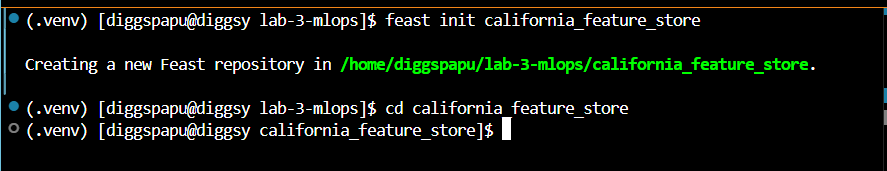

### Definición de Features

In [ ]:
# from feast import Entity, FeatureView, Field, FileSource
# from feast.types import Float64, Int64
# from datetime import timedelta
# # TODO: Definir la entidad (house)
# house = Entity(
#     name='house',
#     join_keys=['house_id']
# )
# # TODO: Definir el source (archivo parquet con los datos)
# house_data_source = FileSource(
#     path="/home/diggspapu/lab-3-mlops/california_feature_store/feature_repo/data/house_features.parquet",  # ruta al archivo parquet
#     timestamp_field="event_timestamp",   # campo de timestamp
#     created_timestamp_column="created",  # opcional: cuándo se creó el registro
# )
# # TODO: Crear FeatureView con las features principales
# house_feature_view = FeatureView(
#     name="house_features",
#     entities=[house],
#     ttl=timedelta(days=1),  # tiempo de vida de los datos en el feature store
#     schema=[
#         Field(name="MedInc", dtype=Int64),
#         Field(name="HouseAge", dtype=Float64),
#         Field(name="AveRooms", dtype=Float64),
#         Field(name="AveBedrms", dtype=Float64),
#         Field(name="Population", dtype=Float64),
#         Field(name="AveOccup", dtype=Float64),
#         Field(name="Latitude", dtype=Float64),
#         Field(name="Longitude", dtype=Float64),
#         Field(name="MedPP", dtype=Float64),
#         Field(name="RatioRoomsBed", dtype=Float64),
#         # Field(name="MedHouseVal", dtype=Float64), # Este no es un feature, es target val.
#     ],
#     source=house_data_source,
#     online=True,  # permite servir en tiempo real
# )

### Materialización de Features

In [42]:
# TODO: Guardar datos en formato parquet con timestamp
df['created'] = pd.Timestamp.now()
df['house_id'] = df.index.astype(int)
df.to_parquet('/home/diggspapu/lab-3-mlops/california_feature_store/feature_repo/data/house_features.parquet',
              compression='snappy') 
# TODO: Ejecutar feast apply
# TODO: Ejecutar feast materialize

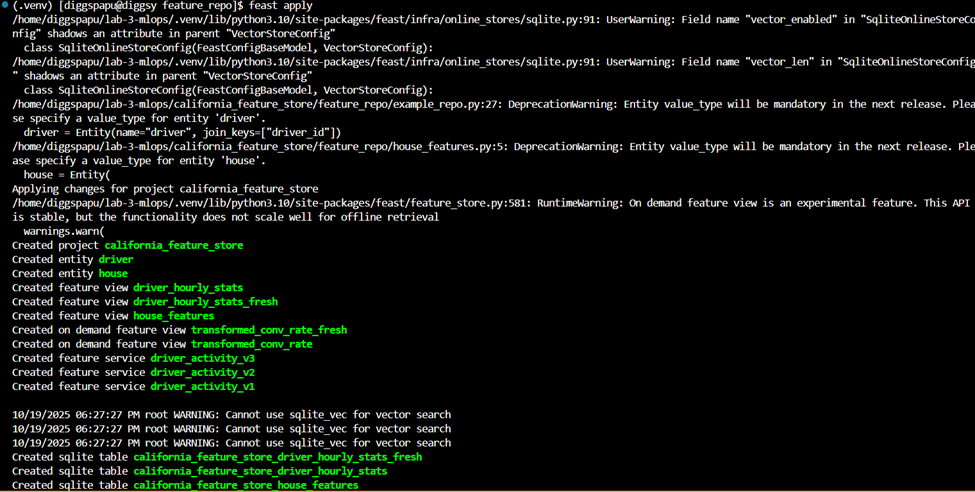
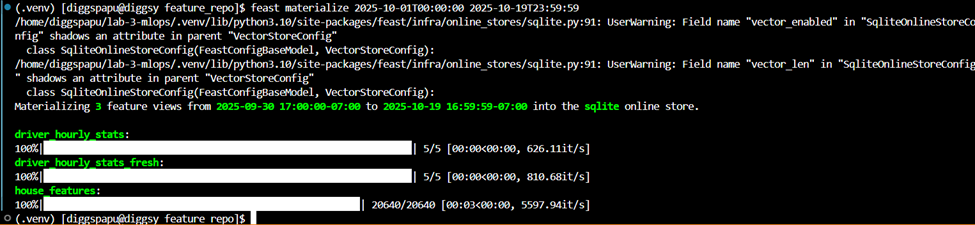

### Consumo de Features

In [43]:
from feast import FeatureStore

# Inicializar el FeatureStore desde el repositorio
store = FeatureStore(repo_path="/home/diggspapu/lab-3-mlops/california_feature_store/feature_repo")
# Lista de entidades para las que quieres recuperar features
entity_df = pd.read_parquet("/home/diggspapu/lab-3-mlops/california_feature_store/feature_repo/data/house_features.parquet")

/home/diggspapu/lab-3-mlops/.venv/lib/python3.10/site-packages/feast/infra/online_stores/sqlite.py:91: UserWarning: Field name "vector_enabled" in "SqliteOnlineStoreConfig" shadows an attribute in parent "VectorStoreConfig"
  class SqliteOnlineStoreConfig(FeastConfigBaseModel, VectorStoreConfig):
/home/diggspapu/lab-3-mlops/.venv/lib/python3.10/site-packages/feast/infra/online_stores/sqlite.py:91: UserWarning: Field name "vector_len" in "SqliteOnlineStoreConfig" shadows an attribute in parent "VectorStoreConfig"
  class SqliteOnlineStoreConfig(FeastConfigBaseModel, VectorStoreConfig):


In [48]:
features = store.get_online_features(
    features=[
        "house_features:MedInc",
        "house_features:HouseAge",
        "house_features:AveRooms",
        "house_features:AveBedrms",
        "house_features:Population",
        "house_features:AveOccup",
        "house_features:Latitude",
        "house_features:Longitude",
        "house_features:MedPP",
        "house_features:RatioRoomsBed",
    ],
    entity_rows=entity_df.to_dict(orient="records")
).to_df()

features.head()

,house_id,AveOccup,Latitude,Population,MedPP,RatioRoomsBed,HouseAge,AveRooms,MedInc,Longitude,AveBedrms
0,0,2.555556,37.88,322.0,3.257687,0.146591,41.0,6.984127,8,-122.23,1.023810
1,1,2.109842,37.86,2401.0,3.934608,0.155797,21.0,6.238137,8,-122.22,0.971880
2,2,2.802260,37.85,496.0,2.589838,0.129516,52.0,8.288136,7,-122.24,1.073446
3,3,2.547945,37.85,558.0,2.214765,0.184458,52.0,5.817352,5,-122.25,1.073059
4,4,2.181467,37.85,565.0,1.763125,0.172096,52.0,6.281853,3,-122.25,1.081081
